# Train Positron Angle Regressor


In [1]:
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import positron_angle_optuna_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")



Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
# Configure the pipeline
# Use absolute path based on project root
# All models use the same source data: mainTimeGroups_*.npy
# NOTE: This pipeline requires load_positron_angle_groups and PositronAngleDataModule to be implemented
file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')
run = positron_angle_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        # Data loading parameters
        'file_pattern': file_pattern,
        'max_files': 1,              # Limit number of files to load
        'limit_groups': 1000,       # Cap total groups for quicker iterations
        'min_hits': 2,
        # Datamodule parameters
        'batch_size': 128,
        'num_workers': None,         # None = auto-detect (uses #CPU cores - 1)
                                     # Set to 0 to disable multiprocessing
                                     # Set to a specific number to override
        'val_split': 0.15,
        'seed': 42,
    },
    run_hparam_search_params={
        'n_trials': 1,               # Optuna trials for the search step
        'max_epochs': 1,             # epochs per trial during search
        'limit_train_batches': 0.4,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
    },
    train_best_model_params={
        'max_epochs': 5,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 6, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: positron_angle_optuna_pipeline.
Caching is disabled by default for positron_angle_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_positron_angle_datamodule has started.


[build_positron_angle_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_positron_angle_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_positron_angle_datamodule] Limiting to 1 files (from 11 total files found, max_files=1)
[build_positron_angle_datamodule] Loaded 1000 groups from 1 files with angle targets
[build_positron_angle_datamodule] Loaded 1000 groups. Building datamodule...


Step build_positron_angle_datamodule has finished in 0.356s.
Step run_positron_angle_hparam_search has started.


[run_positron_angle_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_positron_angle_hparam_search] CUDA devices: 1
[run_positron_angle_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_positron_angle_hparam_search] Dataset sizes - Train: 850, Val: 150
[run_positron_angle_hparam_search] Starting Optuna search with 1 trials, 1 epochs per trial...
[I 2025-12-05 13:56:12,893] A new study created in memory with name: no-name-95a5f8c8-395d-4d86-bb4d-04223ed735be
[run_positron_angle_hparam_search] Starting Optuna study...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_positron_angle_hparam_search] Trial 1/1 starting...
[run_positron_angle_hparam_search] Trial 1 params: batch_size=32, hidden=160 (from 160), heads=4, layers=2, dropout=0.0766, lr=0.008488, weight_decay=0.000014
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_positron_angle_hparam_search] Trial 1 training 1 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PositronAngleModel │  724 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss            │      0 │ train │     0 │
└───┴─────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 724 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 724 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 46                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[run_positron_angle_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_positron_angle_hparam_search] Trial 1 completed with score: 0.000127
[run_positron_angle_hparam_search] Optuna search complete! Best score: 0.000127
[run_positron_angle_hparam_search] Best params: {'batch_size': 32, 'hidden': 160, 'heads': 4, 'layers': 2, 'dropout': 0.07660541170204452, 'lr': 0.008488022769423648, 'weight_decay': 1.4100179603797994e-05}


[I 2025-12-05 13:56:16,606] Trial 0 finished with value: 0.00012724520530063265 and parameters: {'batch_size': 32, 'hidden': 160, 'heads': 4, 'layers': 2, 'dropout': 0.07660541170204452, 'lr': 0.008488022769423648, 'weight_decay': 1.4100179603797994e-05}. Best is trial 0 with value: 0.00012724520530063265.
Step run_positron_angle_hparam_search has finished in 3.841s.
Step train_best_positron_angle_regressor has started.


[train_best_positron_angle_regressor] Starting final model training...
[train_best_positron_angle_regressor] Dataset sizes - Train: 850, Val: 150
[train_best_positron_angle_regressor] Using GPU: NVIDIA GeForce RTX 5070
[train_best_positron_angle_regressor] CUDA devices: 1
[train_best_positron_angle_regressor] Enabled Tensor Core optimization (medium precision)
[train_best_positron_angle_regressor] Training configuration:
[train_best_positron_angle_regressor]   max_epochs: 5
[train_best_positron_angle_regressor]   early_stopping: True
[train_best_positron_angle_regressor]   early_stopping_patience: 6
[train_best_positron_angle_regressor] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PositronAngleModel │  724 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss            │      0 │ train │     0 │
└───┴─────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 724 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 724 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 46                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 5113.640
Metric val_loss improved by 44.239 >= min_delta = 0.0. New best score: 5069.401
Metric val_loss improved by 148.896 >= min_delta = 0.0. New best score: 4920.505
`Trainer.fit` stopped: `max_epochs=5` reached.


[train_best_positron_angle_regressor] Training complete! Final epoch: 6


Step train_best_positron_angle_regressor has finished in 9.777s.
Step collect_positron_angle_predictions has started.
Step collect_positron_angle_predictions has finished in 2.140s.
Pipeline run has finished in 17.568s.
Run name: positron_angle_optuna_pipeline-2025_12_05-18_56_11_673329
Run status: completed


In [3]:
# Load artifacts from the pipeline run
trained_module = load_step_output(run, "train_best_positron_angle_regressor")
datamodule = load_step_output(run, "build_positron_angle_datamodule")
predictions = load_step_output(run, "collect_positron_angle_predictions", index=0)
targets = load_step_output(run, "collect_positron_angle_predictions", index=1)
best_params = load_step_output(run, "run_positron_angle_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))



Loaded module on cpu; validation samples: 150
Best params from Optuna: {'batch_size': 32, 'hidden': 160, 'heads': 4, 'layers': 2, 'dropout': 0.07660541170204452, 'lr': 0.008488022769423648, 'weight_decay': 1.4100179603797994e-05, 'best_score': 0.00012724520530063265, 'n_trials': 1} {'batch_size': 32, 'hidden': 160, 'heads': 4, 'layers': 2, 'dropout': 0.07660541170204452, 'lr': 0.008488022769423648, 'weight_decay': 1.4100179603797994e-05, 'best_score': 0.00012724520530063265, 'n_trials': 1}
Epochs actually run: 6 6


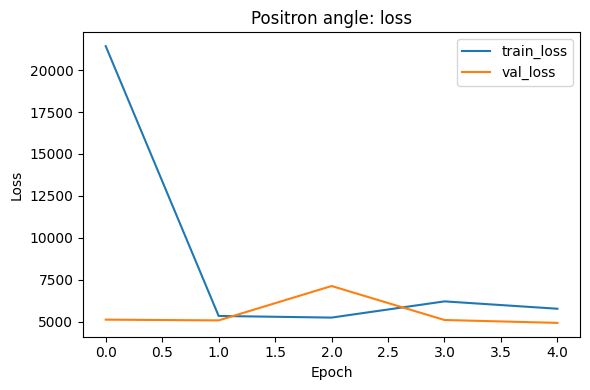

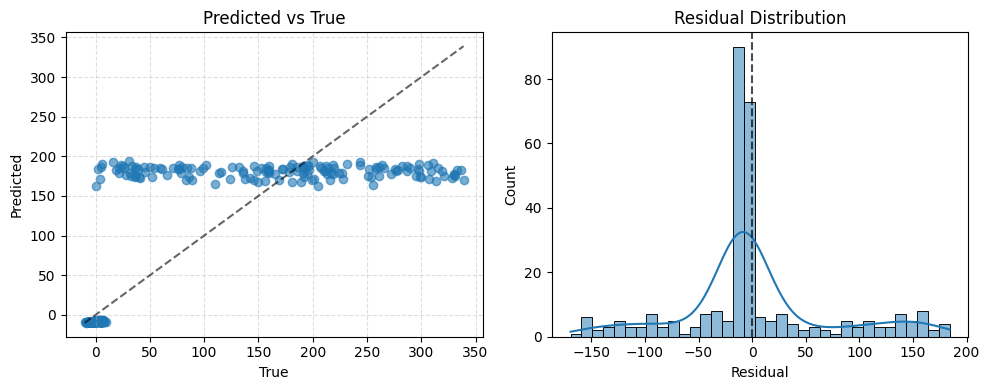

In [4]:
from pioneerml.evaluation.plots import plot_loss_curves, plot_regression_diagnostics

# Loss curves
plot_loss_curves(trained_module, title="Positron angle: loss", show=True)

# Regression diagnostics
plot_regression_diagnostics(predictions=predictions, targets=targets, show=True)


In [5]:
# Save trained positron angle model checkpoint
from datetime import datetime
import torch

ckpt_dir = Path(PROJECT_ROOT) / "trained_models" / "positron_angle"
ckpt_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = ckpt_dir / f"positron_angle_{timestamp}.pt"
#torch.save(trained_module.model.state_dict(), ckpt_path)
print(f"Saved checkpoint to {ckpt_path}")


Saved checkpoint to /home/jack/python_projects/pioneerML/trained_models/positron_angle/positron_angle_20251205_135630.pt
